In [6]:
# Globally required imports
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(1)

# Matrix Product State Pretraining - Introduction

## Matrix Product States

Matrix Product States (MPS) are factorizations of tensors with a potentially large number of indices into the contraction of many three-index tensors.
\begin{align*}
T_{i_1,i_2,\cdots i_n} &= \sum_{\{j\}} A^{(1)}_{i_1; j_1} A^{(2)}_{i_2; j_1, j_2} \cdots A^{(n-1)}_{i_{n-1}; j_{n-1}, j_{n}} A^{(n)}_{i_n; j_n} \\
&= \text{Tr}(A^{(1)}_{i_1}A^{(2)}_{i_2} \cdots A^{(n)}_{i_n})
\end{align*}

Quantum states are amenable to be represented by MPS's,
\begin{align*}
\ket{\psi} = \sum_{\{i\}}\text{Tr}\left[ A^{(1)}_{i_1}A^{(2)}_{i_2} \cdots A^{(n)}_{i_n})
    \right] \ket{i_{1}i_{2}\cdots i_{n}},
\end{align*}

where $A^{(i)}_\ell$ are complex, square matrices of at most order $\chi$, which is the so-called bond dimension of the MPS.

While this factorizations may represent any tensor, this could require an arbitrarily large bond dimension $\chi$, able to represent the exponentially large space state. However, it is customary to truncate the bond dimension of the MPS, decreasing the size of the resulting state space, and yielding a very efficient and classically tractable method to aproximate the desired quantum states.

## MPS pretraining

In [1], the authors propose a training procedure for quantum circuits, which consists in first considering a circuit ansatz that
may be well represented by an MPS with low bond dimension,

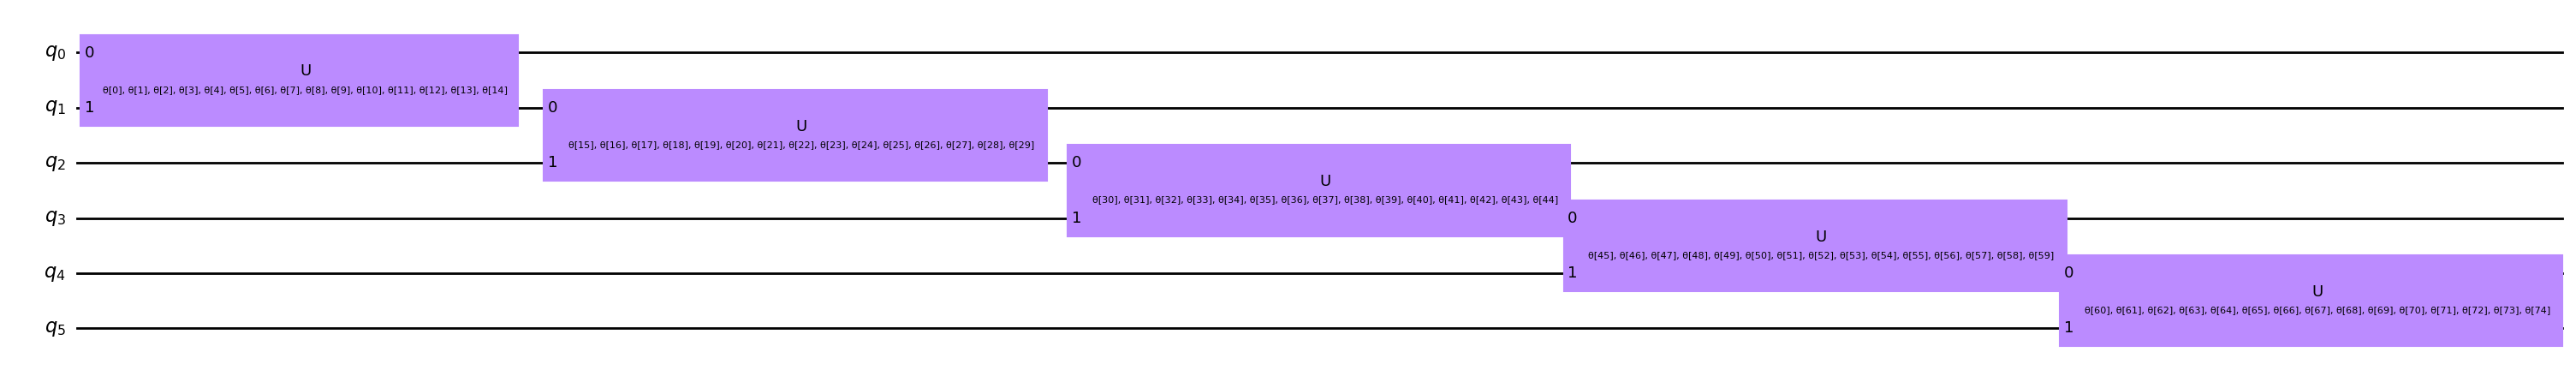

In [7]:
from qubap.qiskit.mps_pretraining import Ansatz

num_qubits = 6
qc_mps = Ansatz(num_qubits, diagonal=True)
qc_mps.draw('mpl', fold=-1)

And simulating it via classical tensor networks to find a set of parameters that optimize the circuit for the desired task.

After this pretraining stage, it is proposed to form a full quantum circuit with much higher expresivity,

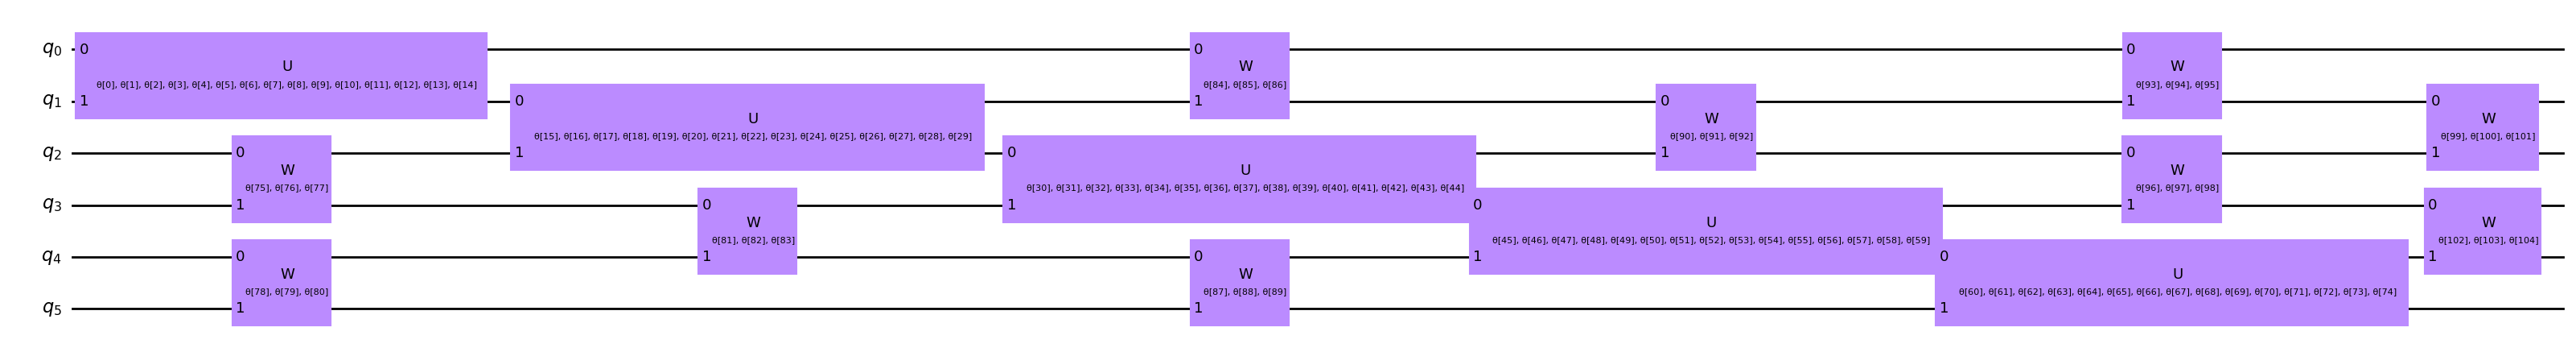

In [8]:
qc_full = Ansatz(num_qubits, diagonal=False)
qc_full.draw('mpl', fold=-1)

and only then use the quantum resources to optimize the full circuit, with initial parameters given that all `W` gates are initialized as identities and the `U` gates are optimized according to the MPS pretraining.

One may use this procedure to initialize variational quantum algorithms from a good approximation of the optimal parameters, consequently avoiding barren plateaus, and even providing speedups to already convergent routines. In practice, this may lead to a drastical reduction of the ammount of quantum resources required.

# Seeing MPS pretraining in practice

## MPS pretraining

Lets consider a Haimltonian whose ground state cannot be represented by a bound-2 MPS: the two-dimensional Ising ladder with nearest-neighbor interactions and transverse magnetic field.

In [9]:
from qubap.qiskit.hamiltonians import ladder_hamiltonian

num_qubits = 6

H = ladder_hamiltonian(num_qubits, transverse_field_intensity=0.1)
H

PauliSumOp(SparsePauliOp(['ZZIIII', 'ZIZIII', 'IZIZII', 'IIZZII', 'IIZIZI', 'IIIZIZ', 'IIIIZZ', 'XIIIII', 'IXIIII', 'IIXIII', 'IIIXII', 'IIIIXI', 'IIIIIX'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 0.1+0.j,
 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j]), coeff=1.0)

We first define the MPS-representable circuit and optimize it. In this training stage we use the MPS interface provided by the `qiskit_aer.AerSimulator` simulator.

In [10]:
# MPS circuit
qc_mps = Ansatz(num_qubits, diagonal=True)

# MPS simulator
from qiskit_aer import AerSimulator

# Backend to simulate the circuit via MPS
backend_mps = AerSimulator(method='matrix_product_state')

# Random initial parameters
params_mps = np.random.rand(qc_mps.num_parameters) * np.pi

# Perform optimization
from qubap.qiskit.variational_algorithms import VQE

num_iters_training = 200 # Pretraining iterations

results_mps = VQE(H, qc_mps, params_mps, num_iters_training, backend_mps)

This is a plot for the estimated energy of the Hamiltonian during the MPS pretraining process. We can see that it got below the level obtained from the initial random parameters.

Text(0.5, 1.0, 'Hamiltoninan energy during the MPS pretraining process')

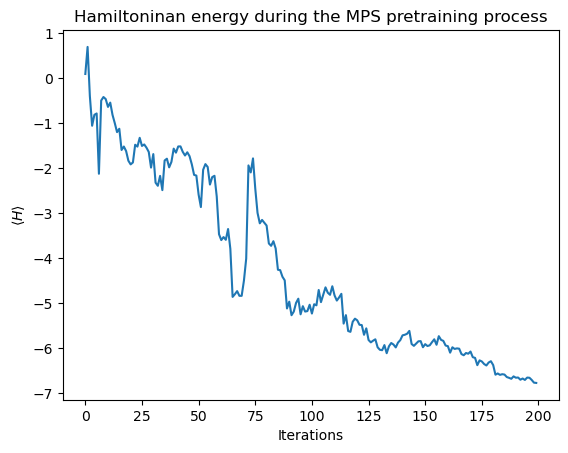

In [11]:
plt.plot(results_mps['fx'])
plt.xlabel('Iterations')
plt.ylabel(r'$\langle H \rangle$')
plt.title("Hamiltoninan energy during the MPS pretraining process")

## Full hybrid quantum-classical optimization 
And now, we can use the resulting parameters from the MPS pretraining into the circuit to run involving quantum resources.


In [12]:
# Number of shots
num_shots = 2**4

# Number of iterations
num_iters = 200

# Full circuit with off-diagonal terms
qc_full = Ansatz(num_qubits, diagonal=False)

# Quantum backend simulator
backend_full = AerSimulator(shots = num_shots)

# Initial parameters. They make the full circuit mimic the initial MPS ansatz
sol_mps = np.mean(results_mps['x'][-10:], axis=0)
params_full = np.append(sol_mps, np.zeros(qc_full.num_parameters - len(sol_mps)))

# Perform optimization. Since we are close to the solution, we pass
# the `iter_start` option to our VQE so that the SPSA optimizer does
# not perturb the initial condition too much.
results_full = VQE(H, qc_full, params_full, num_iters, backend_full,
                   iter_start=num_iters_training)

For the sake of comparison, we also run the VQE naively, without pretraining, with the same number of iterations,

In [13]:
params_naive = np.random.rand( qc_full.num_parameters ) * np.pi
results_naive = VQE(H, qc_full, params_naive, num_iters, backend_full)

and make a plot to compare both results, from the pretrained VQE and the naive VQE

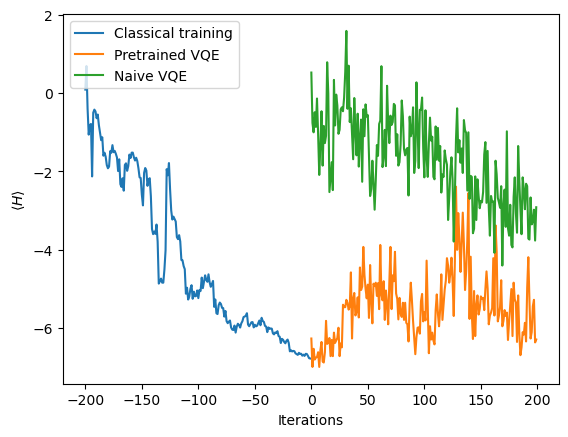

In [14]:
plt.plot(range(-num_iters_training, 0), results_mps['fx'], label='Classical training')
plt.plot(results_full['fx'],  label='Pretrained VQE')
plt.plot(results_naive['fx'], label='Naive VQE')
plt.xlabel('Iterations')
plt.ylabel(r'$\langle H \rangle$')
plt.legend()

# All the pieces together

Having shown that the pretraining process works as expected, we provide an automated interface to accomplish the procedure, instead of performing it by hand as before.
This interface is `VQE_pretrained`, which can be imported from `qubap.qiskit.mps_pretraining`.

In [15]:
from qubap.qiskit.mps_pretraining import VQE_pretrained

# We don't provide circuit or parameters, as it is automatic
results_pretrained = VQE_pretrained(H, backend_full, num_iters, num_iters_training)

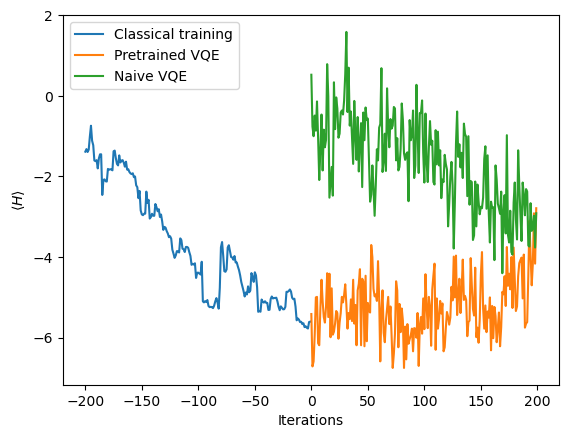

In [16]:
energy_naive    = results_naive['fx']
energy_full     = results_pretrained['full']['fx']
energy_training = results_pretrained['pretrain']['fx']

plt.plot(range(-num_iters_training, 0), energy_training, label='Classical training')
plt.plot(energy_full,  label='Pretrained VQE')
plt.plot(energy_naive, label='Naive VQE')
plt.xlabel('Iterations')
plt.ylabel(r'$\langle H \rangle$')
plt.legend()

# Is MPS pretraining really better than preparing with a usual simulation?

If one measures the time simulating the pretraining vs the usual VQE stage, it seems that
the MPS simulation takes even a little more time than the default method from `qiskit.AerSimulator`.
Well, this is because we are working with a very small ammount of qubits, which makes the problem amenable to
classical simulation.

If we needed to run a similar problem for a larger number of qubits, we would realize that the
default simulation becomes unfeasible, while the resources required for the MPS pretraining scale much better.

To illustrate the resource scaling in both cases, we perform a benchmark below: We define a function to measure the execution time to evaluate a single energy evaluation, which we apply to circuits and Hamiltonians with increasing qubit count.

In [17]:
from time import time
def measure_time(f, *args, **kwargs):
    '''
    Measure time in seconds.
    Runs a given function and returns the time elapsed and the function's result.
    '''
    start_time = time()
    result = f(*args, **kwargs)
    elapsed = time() - start_time
    return elapsed, result

In [18]:
from qubap.qiskit.variational_algorithms import energy_evaluation

max_qubits = 50         # MPS allows a much higher qubit count
max_qubits_default = 28 # Requires ~16Gb RAM with AerSimulator default 
backend_mps     = AerSimulator(method='matrix_product_state')
backend_default = AerSimulator()

qubits_default, times_default = [], []
qubits_mps,     times_mps     = [], []
for num_qubits in range(2, max_qubits+1):
    # Circuit ansatz and Hamiltonian with `num_qubits` qubits
    H  = ladder_hamiltonian(num_qubits)
    qc = Ansatz(num_qubits, diagonal=True)

    # Random parameters to feed the circuit
    params = np.random.rand(qc.num_parameters)

    # Measure time from MPS backend
    secs_mps, _ = measure_time(energy_evaluation, H, qc, params, backend_mps)
    qubits_mps.append(num_qubits)
    times_mps.append(secs_mps)

    # Measure time from default backend
    if num_qubits < max_qubits_default: # More qubits kill my computer
        secs_def, _ = measure_time(energy_evaluation, H, qc, params, backend_default)
        qubits_default.append(num_qubits)
        times_default.append(secs_def)


Text(0.5, 1.0, 'Time for a single Energy evaluation')

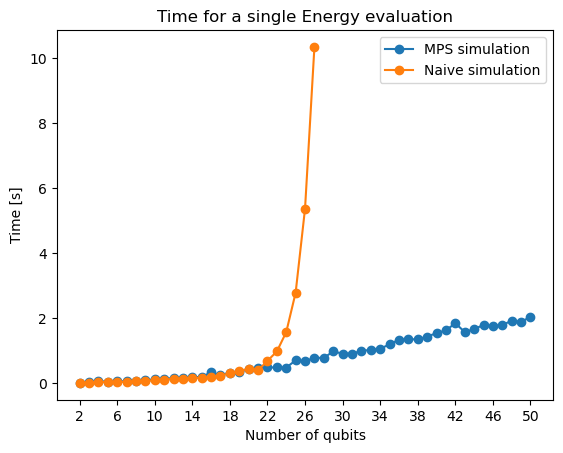

In [19]:
plt.plot(qubits_mps, times_mps, '-o', label='MPS simulation')
plt.plot(qubits_default, times_default, '-o', label='Naive simulation')
plt.xticks(qubits_mps[::4])
plt.legend()
plt.xlabel('Number of qubits')
plt.ylabel('Time [s]')
plt.title('Time for a single Energy evaluation')

For a small number of qubits the MPS simulation takes a little bit more than the default classical simulation. Anyways, we can see that the resources required scale prohitively in the case of a usual simulation, while the MPS simulation can be extended even beyond 50 qubits in my personal laptop.

# References
[1] : Matrix product state pre-training for quantum machine learning, Quantum Sci. Technol. 7, 035014 (2022)

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table